## Import libraries<a name="import"></a>

In [23]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np

from my_functions import *


### Ensure that the root directory is the project directory
In some cases, the root directory may not be the project directory. This is usually the case when the notebook is run from a subdirectory of the project directory.

In [24]:
# if pwd is SRC  change to root
print("Current working directory: ", os.getcwd())
if os.path.basename(os.getcwd()) == "SRC":
    os.chdir("..")
print("Current working directory: ", os.getcwd())
print(os.path.basename(os.getcwd()))

Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Stage_Signal_Physio


In [25]:
plt.close("all")  # close all figure windows

## Initialization

### Xdf file selection and loading (REARM data)

In [26]:
# Define the xdf file of interest
xdf_input_filename="001_MolLud_20201112_1_c.xdf"
#xdf_input_filename="020_DesMar_20211129_1_c.xdf"

xdf_input_filepath=os.path.normpath("DAT/INPUT/"+xdf_input_filename)

In [27]:
# definition of the EEG channels' names
channels_dict = {"Channel_1": "C4",
                "Channel_2": "FC2",
                "Channel_3": "FC6",
                "Channel_4": "CP2",
                "Channel_5": "C3",
                "Channel_6": "FC1",
                "Channel_7": "FC5",
                "Channel_8": "CP1"}

In [28]:
test0=retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,stream_type="EEG")
print(test0["infos"]["channels"]["names"])
print(test0["infos"]["channels"]["units"])

Accessing stream: 
Type: 'EEG' | Name: 'LSLOutletStreamName-EEG'
['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8']
['microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts']


### Retrieve EEG data

In [29]:
EEG_data=retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,stream_type="EEG")

EEG_timestamps = EEG_data["data"]["timestamps"]-EEG_data["data"]["timestamps"][0]
EEG_srate=EEG_data["infos"]["sample_rate"]["effective"]

EEG_amplitudes_centered = detrend_signals(EEG_data["data"]["time_series"])
EEG_amplitudes_rereferenced = rereference_signals(input_signals=EEG_amplitudes_centered)
EEG_amplitudes_centered_filtered,_,_ = filter_signal(input_signals=EEG_amplitudes_rereferenced,
                                            sample_rate=EEG_srate,

                                            order=8,cutofffreq=(5,100,50))


Accessing stream: 
Type: 'EEG' | Name: 'LSLOutletStreamName-EEG'
input_signals shape:
 (221938, 8)
input_signals mean per signal:
 [27897.195 26144.139 28026.402 35319.527 31324.672 24827.713 32372.799
 29788.95 ]
input_signals shape:(221938, 8)
input_signals whole mean:13.818697929382324
LOW_CUTOFF_FREQ_THEORETICAL=5,HIGH_CU-TOFF_FREQ_THEORETICAL=100
LOW_CUTOFF_FREQ_CORRECTED=4.732,HIGH_CUTOFF_FREQ_CORRECTED=104.203
NOTCH_CUTOFF_FREQ=50
Filtered signal shape: (221938, 8)


### Retrieve mouse marker data

In [30]:
mouse_marker_times_labels = create_marker_times_labels_array2(xdf_input_filepath=xdf_input_filepath)
mouse_marker_times_labels[:,0] -= EEG_data["data"]["timestamps"][0] #make times start in reference to the first EEG timestamp instead of unix epoch.

Accessing stream: 
Type: 'Markers' | Name: 'MouseToNIC'


### Epoch EEG Data

In [31]:
#epoch EEG signals
nearest_markers_array = nearest_timestamps_array_finder(EEG_times_stamps=EEG_timestamps,markers=mouse_marker_times_labels)
EEG_C4_epoched = extract_data_epochs(signal=EEG_amplitudes_centered_filtered[:,0],sample_rate=EEG_data["infos"]["sample_rate"]["effective"],
                                   markers_labels_times=nearest_markers_array,select_events=(111,100),epoch_limits=(0,2))

MARKERS LEN: 12
Epoch limits relative to events (in sec): before: 0s - after: 2s
Epoch limits relative to events (in samples): n_points_before_marker: 0.0 - n_points_after_marker: 999.995454087033
Event type : 111 ------------ epochs :
first_seg_coord: 13659 - second_seg_coord: 14658
first_seg_coord: 33660 - second_seg_coord: 34659
first_seg_coord: 53662 - second_seg_coord: 54661
first_seg_coord: 82834 - second_seg_coord: 83833
first_seg_coord: 102836 - second_seg_coord: 103835
first_seg_coord: 122837 - second_seg_coord: 123836
signal_segments shape: (1000, 6)
time_segments shape: (1000, 6)
Event type : 100 ------------ epochs :
first_seg_coord: 23660 - second_seg_coord: 24659
first_seg_coord: 43661 - second_seg_coord: 44660
first_seg_coord: 63663 - second_seg_coord: 64662
first_seg_coord: 92835 - second_seg_coord: 93834
first_seg_coord: 112837 - second_seg_coord: 113836
first_seg_coord: 132838 - second_seg_coord: 133837
signal_segments shape: (1000, 6)
time_segments shape: (1000, 6)


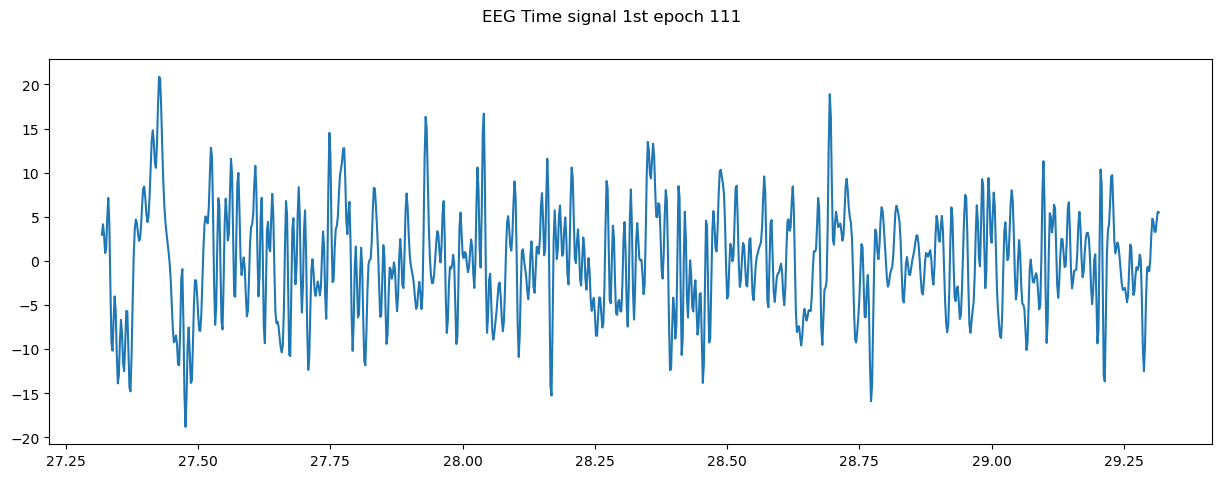

In [32]:
figure,axis=plt.subplots(1,figsize=(15,5))
figure.suptitle("EEG Time signal 1st epoch 111")
axis.plot(EEG_C4_epoched["label_111"]["time_segments"][:,0],EEG_C4_epoched["label_111"]["signal_segments"][:,0])

### Mouse mocap : Retrieve and shape data

In [33]:
mouse_mocap_data = retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,stream_type="MoCap",stream_name="Mouse")

mouse_mocap_positions_units = np.unique(mouse_mocap_data["infos"]["channels"]["units"][0:2])[0]
mouse_mocap_sample_rate = mouse_mocap_data["infos"]["sample_rate"]["effective"]
mouse_mocap_times = mouse_mocap_data["data"]["timestamps"]-EEG_data["data"]["timestamps"][0] #make times start relative to the first EEG timestamp instead of unix epoch.
mouse_mocap_positions_xy = mouse_mocap_data["data"]["time_series"][:,0:2] #select only x and y position data


Accessing stream: 
Type: 'MoCap' | Name: 'Mouse'


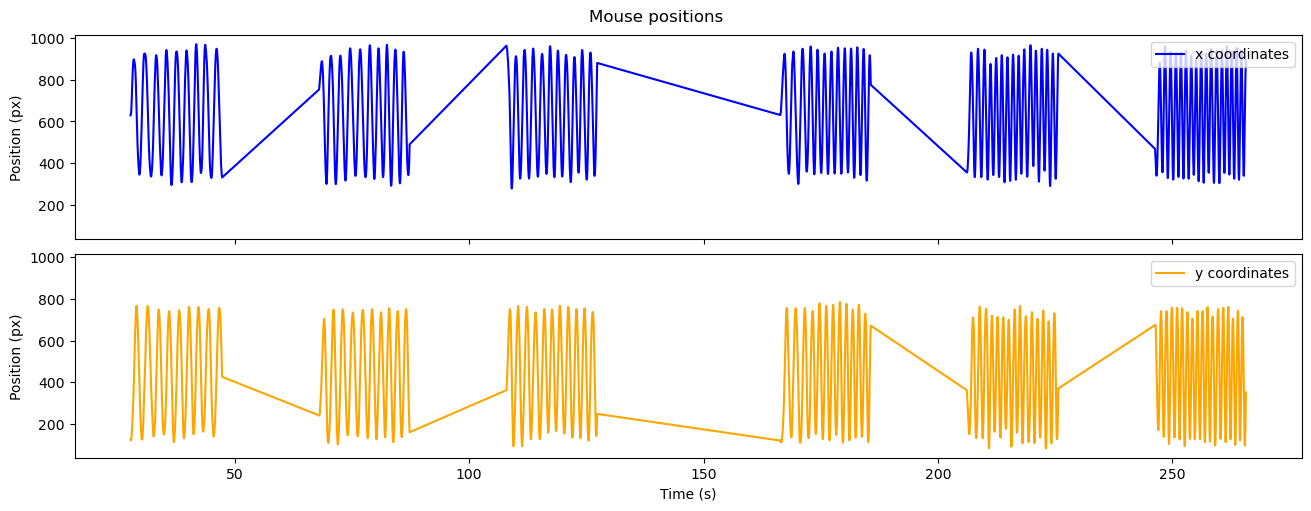

In [34]:
figure,axis=plt.subplots(2, sharex=True, sharey=True, layout="constrained", figsize=(13,5))
figure.suptitle("Mouse positions")

axis[0].plot(mouse_mocap_times,mouse_mocap_positions_xy[:,0], label="x coordinates",color="b")
axis[0].set_ylabel("Position (px)")
axis[0].legend(loc="upper right")

axis[1].plot(mouse_mocap_times,mouse_mocap_positions_xy[:,1], label="y coordinates",color="orange")
axis[1].set_ylabel("Position (px)")
axis[1].set_xlabel("Time (s)")
axis[1].legend(loc="upper right")


### EEG accelerometer : Retrieve and shape data

In [41]:
eeg_accelerometer_data = retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath,stream_type="Accelerometer")

eeg_accelerometer_units = np.unique(eeg_accelerometer_data["infos"]["channels"]["units"])[0]
eeg_accelerometer_sample_rate = eeg_accelerometer_data["infos"]["sample_rate"]["effective"]
eeg_accelerometer_times = eeg_accelerometer_data["data"]["timestamps"]-EEG_data["data"]["timestamps"][0] #make times start relative to the first EEG timestamp instead of unix epoch.
eeg_accelerometer_xyz = eeg_accelerometer_data["data"]["time_series"]


Stream 9: Calculated effective sampling rate 499.9721 Hz is different from specified rate 100.0000 Hz.


Accessing stream: 
Type: 'Accelerometer' | Name: 'LSLOutletStreamName-Accelerometer'
mm/s2


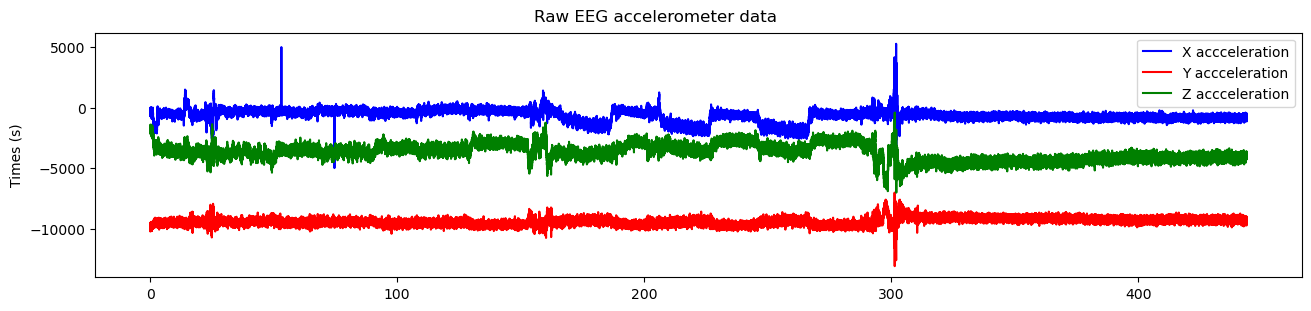

In [53]:
figure,axis=plt.subplots(1, layout="constrained", figsize=(13,3))
figure.suptitle("Raw EEG accelerometer data")

axis.plot(eeg_accelerometer_times,eeg_accelerometer_xyz[:,0], label="X accceleration",color="b")
axis.plot(eeg_accelerometer_times,eeg_accelerometer_xyz[:,1], label="Y accceleration",color="r")
axis.plot(eeg_accelerometer_times,eeg_accelerometer_xyz[:,2], label="Z accceleration",color="g")

axis.set_ylabel(f"Acceleration ({eeg_accelerometer_units})")
axis.set_ylabel(f"Times (s)")

axis.legend(loc="upper right")


### Compute mouse tangential speeds

In [37]:
mouse_mocap_speeds = compute_tangential_speed(coordinates=mouse_mocap_positions_xy,
                                            sample_rate=mouse_mocap_sample_rate)

mouse_mocap_speeds_threshold = 0.05*np.max(mouse_mocap_speeds)
print(f"mouse_mocap_speed_threshold = {mouse_mocap_speeds_threshold} ({mouse_mocap_positions_units}/s) ")

print(f"vt_max= {np.max(mouse_mocap_speeds)} ({mouse_mocap_positions_units}/s)")
print(f"vt_min= {np.min(mouse_mocap_speeds)} ({mouse_mocap_positions_units}/s)")
print(f"vt_moy= {np.mean(mouse_mocap_speeds)} ({mouse_mocap_positions_units}/s)")

mouse_mocap_speed_threshold = 3013.5616374589035 (pixels/s) 
vt_max= 60271.23274917807 (pixels/s)
vt_min= 93.92532860411228 (pixels/s)
vt_moy= 1270.3016690899083 (pixels/s)


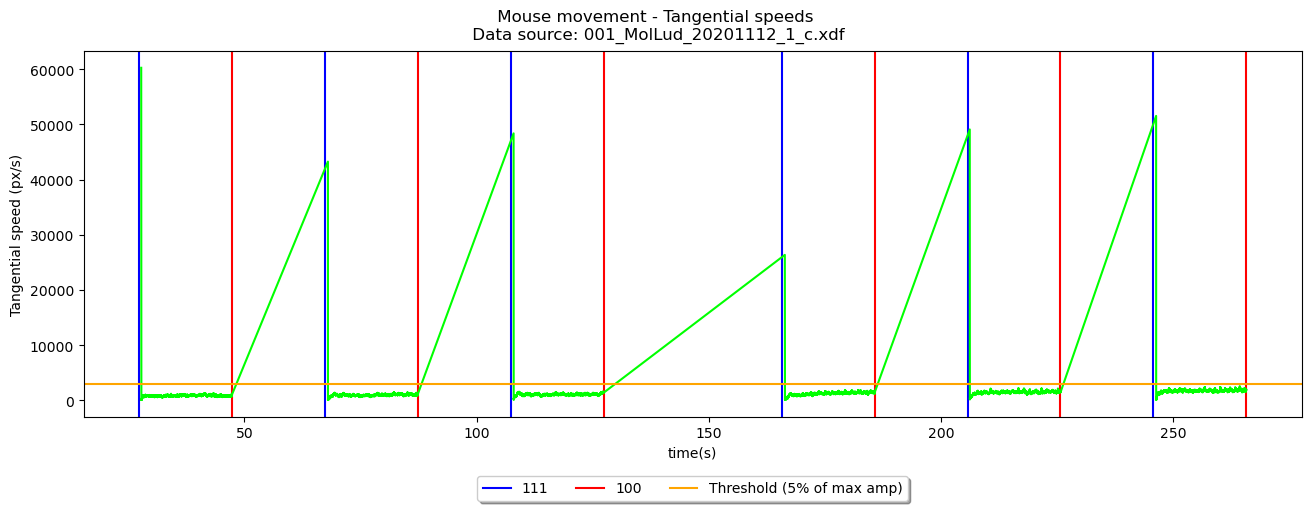

In [38]:
figure,axis=plt.subplots(layout="constrained",figsize=(13,5))
figure.suptitle(f" Mouse movement - Tangential speeds \n Data source: {xdf_input_filename}")

show_markers2(plot_type=axis, markers_times_array=mouse_marker_times_labels)
axis.plot(mouse_mocap_times,mouse_mocap_speeds,color="lime",linewidth=1.5)

axis.axhline(mouse_mocap_speeds_threshold,label="Threshold (5% of max amp)",color="orange")
axis.set_ylabel("Tangential speed (px/s)")
axis.set_xlabel("time(s)")
axis.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3)

In [39]:
#Select EEG channel
print(channels_dict)
selected_channel_num=[1,5]


{'Channel_1': 'C4', 'Channel_2': 'FC2', 'Channel_3': 'FC6', 'Channel_4': 'CP2', 'Channel_5': 'C3', 'Channel_6': 'FC1', 'Channel_7': 'FC5', 'Channel_8': 'CP1'}


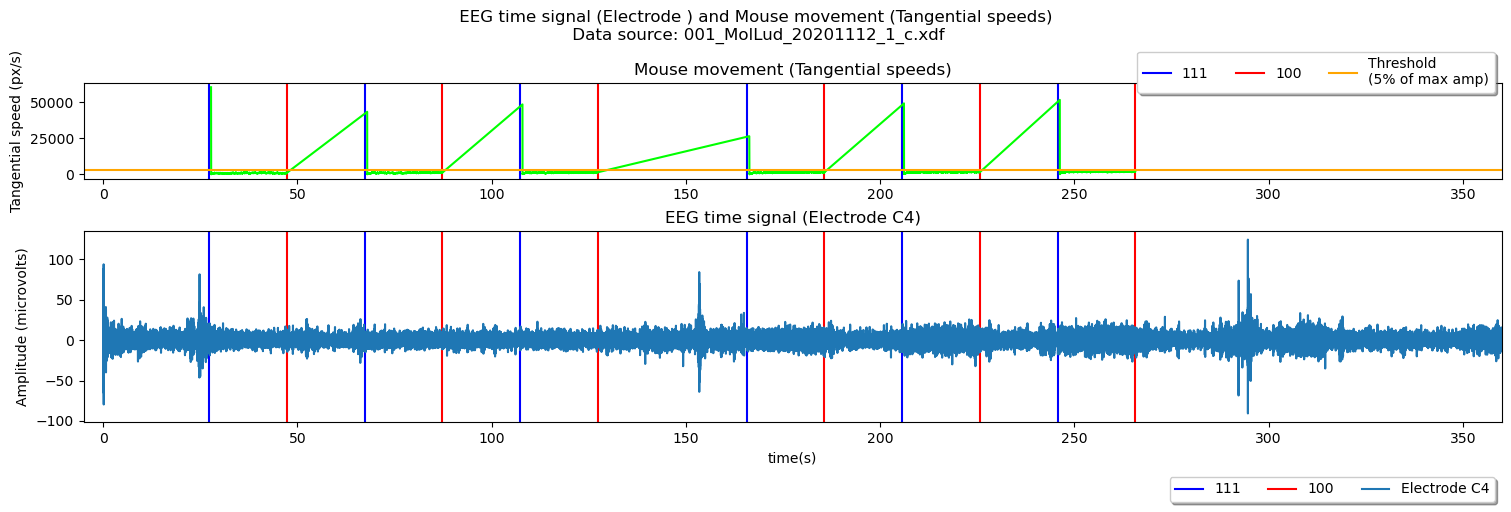

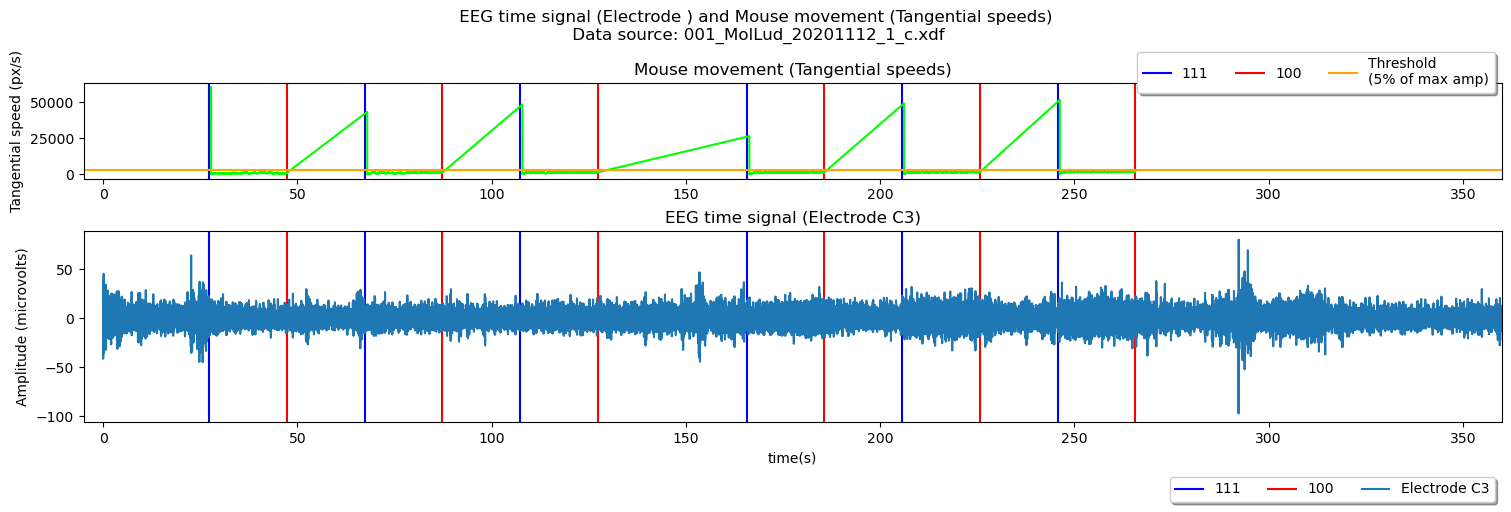

In [40]:
for channel in selected_channel_num:
    channel_num=channel
    channel_index=channel_num-1 #cf python indexing

    figure,axis=plt.subplots(2,layout="constrained",figsize=(15,5),gridspec_kw={'height_ratios': [1, 2]})
    figure.suptitle(f" EEG time signal (Electrode ) and Mouse movement (Tangential speeds) \n Data source: {xdf_input_filename}")

    show_markers2(plot_type=axis[0], markers_times_array=mouse_marker_times_labels)
    axis[0].plot(mouse_mocap_times,mouse_mocap_speeds,color="lime",linewidth=1.5)
    axis[0].set_title("Mouse movement (Tangential speeds)")
    axis[0].set_xlim(left=-5,right=360)
    axis[0].axhline(mouse_mocap_speeds_threshold,label="Threshold \n(5% of max amp)",color="orange")
    axis[0].set_ylabel("Tangential speed (px/s)")
    axis[0].legend(loc='upper right',bbox_to_anchor=(1, 1.40), fancybox=True, shadow=True, ncol=3)

    show_markers2(plot_type=axis[1], markers_times_array=mouse_marker_times_labels)
    axis[1].plot(EEG_timestamps,EEG_amplitudes_centered_filtered[:,channel_index],label=f"Electrode {channels_dict[f'Channel_{channel_num}']}")
    axis[1].set_title(f"EEG time signal (Electrode {channels_dict[f'Channel_{channel_num}']})")
    axis[1].set_xlim(left=-5,right=360)
    axis[1].set_ylabel(f"Amplitude ({EEG_data['infos']['channels']['units'][0]})")
    axis[1].set_xlabel("time(s)")
    axis[1].legend(loc='upper right',bbox_to_anchor=(1, -0.25), fancybox=True, shadow=True, ncol=3)
